## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Please read the instructions carefully before starting the project.**

This is a commented Python Notebook file in which all the instructions and tasks to be performed are mentioned.
* Blanks '_____' are provided in the notebook that
needs to be filled with an appropriate code to get the correct result. With every '_____' blank, there is a comment that briefly describes what needs to be filled in the blank space.
* Identify the task to be performed correctly, and only then proceed to write the required code.
* Please run the codes in a sequential manner from the beginning to avoid any unnecessary errors.
* Add the results/observations (wherever mentioned) derived from the analysis in the presentation and submit the same. Any mathematical or computational details which are a graded part of the project can be included in the Appendix section of the presentation.

**Note**: If the free-tier GPU of Google Colab is not accessible (due to unavailability or exhaustion of daily limit or other reasons), the following steps can be taken:

1. Wait for 12-24 hours until the GPU is accessible again or the daily usage limits are reset.

2. Switch to a different Google account and resume working on the project from there.

3. Try using the CPU runtime:
    - To use the CPU runtime, click on *Runtime* => *Change runtime type* => *CPU* => *Save*
    - One can also click on the *Continue without GPU* option to switch to a CPU runtime (kindly refer to the snapshot below)
    - The instructions for running the code on the CPU are provided in the respective sections of the notebook.

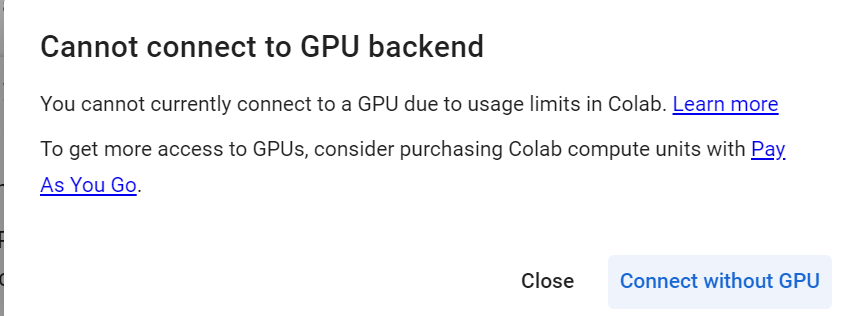

## **Installing and Importing the necessary libraries**

In [1]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install -U sentence-transformers gensim transformers tqdm -q

In [2]:
# To manipulate and analyze data
import pandas as pd
import numpy as np

# To visualize data
import matplotlib.pyplot as plt
import seaborn as sns

# To used time-related functions
import time

# To parse JSON data
import json

# To build, tune, and evaluate ML models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# To load/create word embeddings
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# To work with transformer models
import torch
from sentence_transformers import SentenceTransformer

# To implement progress bar related functionalities
from tqdm import tqdm
tqdm.pandas()

# To ignore unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

## **Loading the dataset**

In [10]:
# # uncomment and run the following code if Google Colab is being used and the dataset is in Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
stock_news = pd.read_csv("stock_news.csv") # Complete the code to read the CSV file.

In [12]:
#Creating a copy of the dataset
stock = stock_news.copy()

## **Data Overview**

### Displaying the first few rows of the dataset

In [13]:
stock.head() # Complete the code to check the first 5 rows of the data

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,This news article reports that yields on long...,41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.740002,42.244999,41.482498,40.246914,130672400,-1


### Understanding the shape of the dataset

In [14]:
stock.shape # Complete the code to check the shape of the data

(349, 8)

### Checking the data types of the columns

In [15]:
stock.dtypes # Complete the code to check the data types

,0
Date,object
News,object
Open,float64
High,float64
Low,float64
Close,float64
Volume,int64
Label,int64


In [16]:
stock['Date'] = pd.to_datetime(stock['Date'])  # to convert the 'Date' column in the 'stock' DataFrame to datetime format.

### Checking the statistical summary

In [17]:
stock.describe() # Complete the code to check the statistical summary

,Date,Open,High,Low,Close,Volume,Label
count,349,349.000000,349.000000,349.000000,349.000000,3.490000e+02,349.000000
mean,2019-02-16 16:05:30.085959936,46.229233,46.700458,45.745394,44.926317,1.289482e+08,-0.054441
min,2019-01-02 00:00:00,37.567501,37.817501,37.305000,36.254131,4.544800e+07,-1.000000
25%,2019-01-14 00:00:00,41.740002,42.244999,41.482498,40.246914,1.032720e+08,-1.000000
50%,2019-02-05 00:00:00,45.974998,46.025002,45.639999,44.596924,1.156272e+08,0.000000
75%,2019-03-22 00:00:00,50.707500,50.849998,49.777500,49.110790,1.511252e+08,0.000000
max,2019-04-30 00:00:00,66.817497,67.062500,65.862503,64.805229,2.444392e+08,1.000000
std,NaN,6.442817,6.507321,6.391976,6.398338,4.317031e+07,0.715119


### Checking the duplicate values

In [18]:
stock.duplicated().sum() #Complete the code to check the duplicate values

0

### Checking for missing values

In [19]:
stock.isnull().sum() # Complete the code to check for missing values in the data

,0
Date,0
News,0
Open,0
High,0
Low,0
Close,0
Volume,0
Label,0


## **Exploratory Data Analysis**

### Univariate Analysis

#### Observations on Label

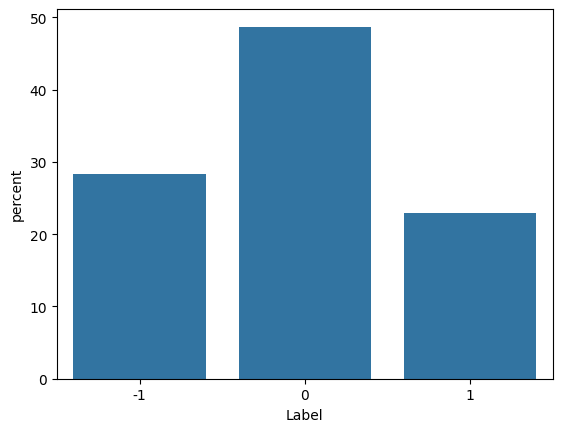

In [20]:
sns.countplot(data=stock, x="Label", stat="percent");

#### Density Plot of Price (Open,High,Low,Close)

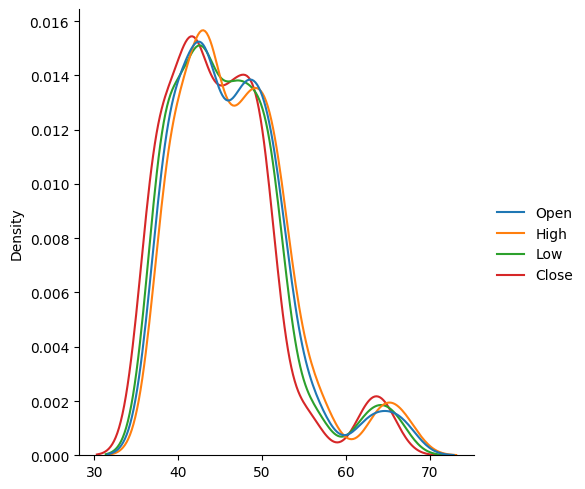

In [21]:
sns.displot(data=stock[['Open', 'High', 'Low', 'Close']], kind="kde", palette="tab10"); # Complete the code to plot a density plot of ["Open","High","Low","Close"] all in a single plot

#### Observations on Volume

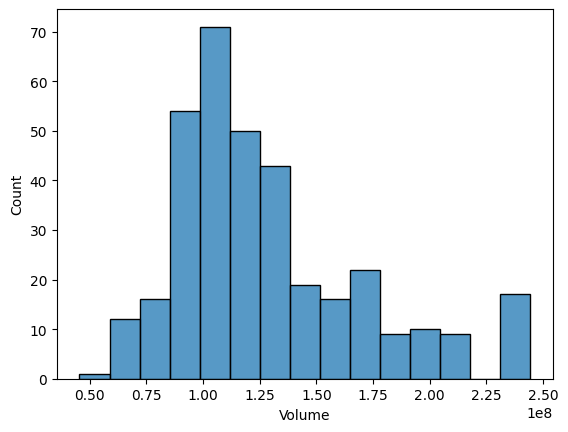

In [22]:
sns.histplot(stock, x='Volume'); # Complete the code to plot a histogram of Volume

#### Observations on News length

In [23]:
#Calculating the total number of words present in the news content.
stock['news_len'] = stock['News'].apply(lambda x: len(x.split(' ')))


stock['news_len'].describe()   #Complete the code to print the statistical summary for the news content length

,news_len
count,349.000000
mean,49.312321
std,5.727770
min,19.000000
25%,46.000000
50%,50.000000
75%,53.000000
max,61.000000


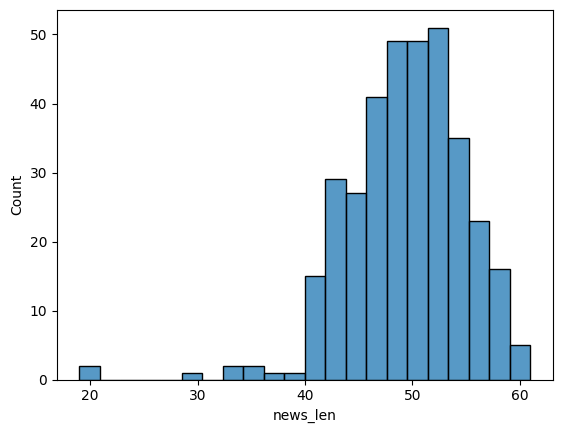

In [24]:
sns.histplot(data=stock,x="news_len"); #Complete the code to plot a histogram of news_len column

### Bivariate Analysis

#### Correlation

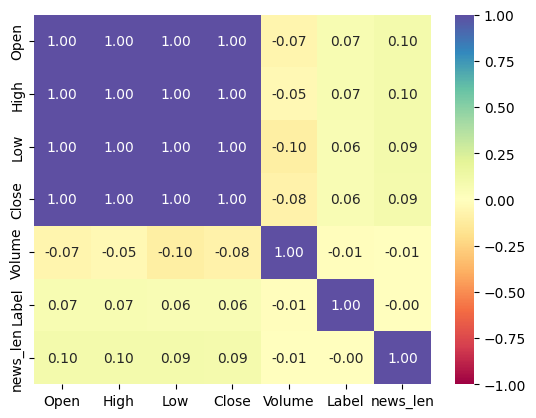

In [25]:
sns.heatmap(
    stock.select_dtypes(include=['number']).corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
);    #Complete the code to plot the correlation matrix for numeric columns only.

#### Label vs Price (Open, High, Low, Close)

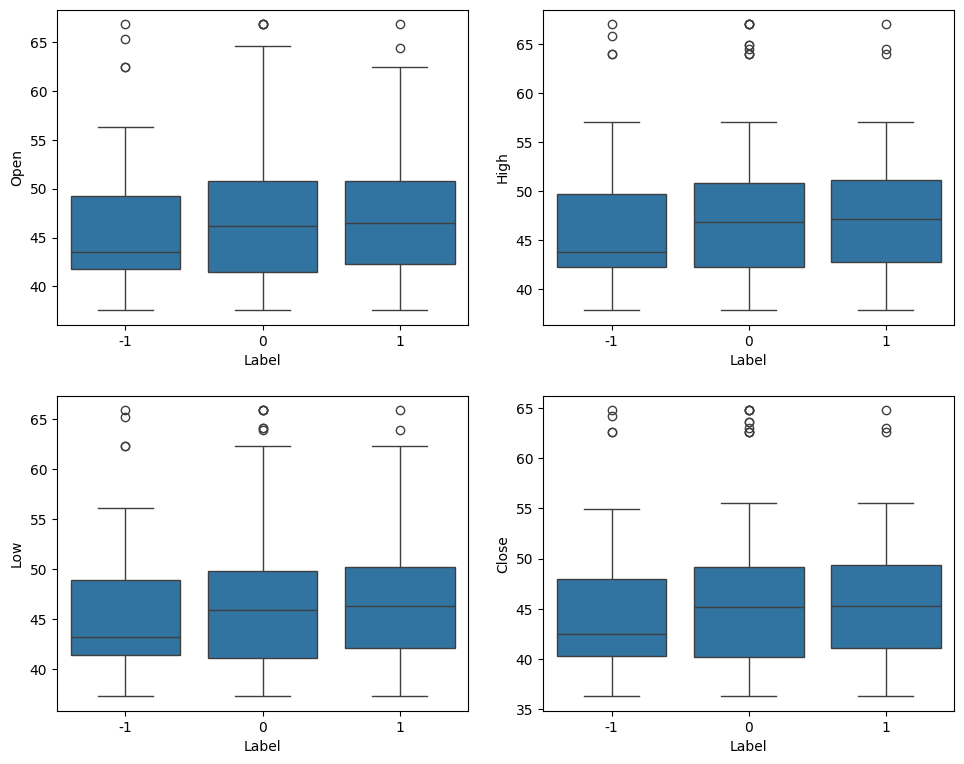

In [26]:
plt.figure(figsize=(10, 8))

for i, variable in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=stock, x="Label", y=variable)
    plt.tight_layout(pad=2)

plt.show()

#### Label vs Volume

<Axes: xlabel='Label', ylabel='Volume'>

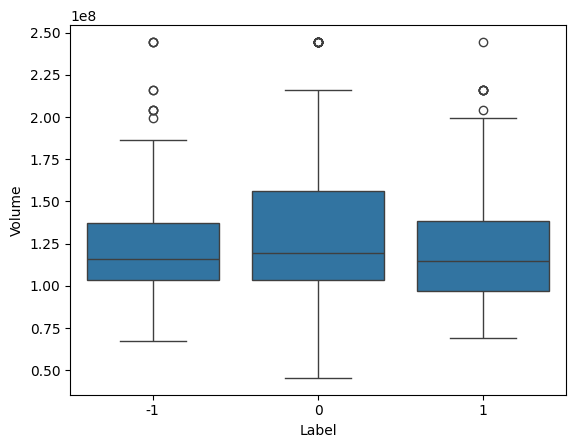

In [27]:
sns.boxplot(
    data=stock, x="Label", y="Volume"  # Complete the code to plot a boxplot of Label vs Volume
)

#### Date vs Price (Open, High, Low, Close)

In [28]:
stock_daily = stock.groupby('Date').agg(
    {
        'Open': 'mean',
        'High': 'mean',
        'Low': 'mean',
        'Close': 'mean',
        'Volume': 'mean',
    }
).reset_index()  # Group the 'stocks' DataFrame by the 'Date' column

stock_daily.set_index('Date', inplace=True)
stock_daily.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02,41.740002,42.244999,41.482498,40.246914,130672400.0
2019-01-03,43.570000,43.787498,43.222500,42.470604,103544800.0
2019-01-04,47.910000,47.919998,47.095001,46.419842,111448000.0
2019-01-07,50.792500,51.122501,50.162498,49.110790,109012000.0
2019-01-08,53.474998,54.507500,51.685001,50.787209,216071600.0


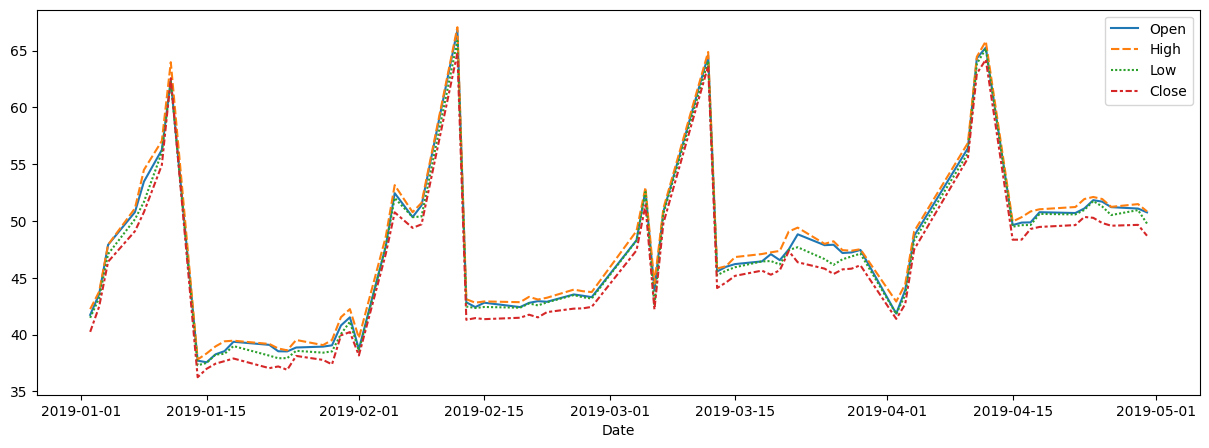

In [29]:
plt.figure(figsize=(15,5))
sns.lineplot(stock_daily.drop("Volume", axis=1)); #Complete the code to plot a lineplot of all the variables except Volume

#### Volume vs Close Price

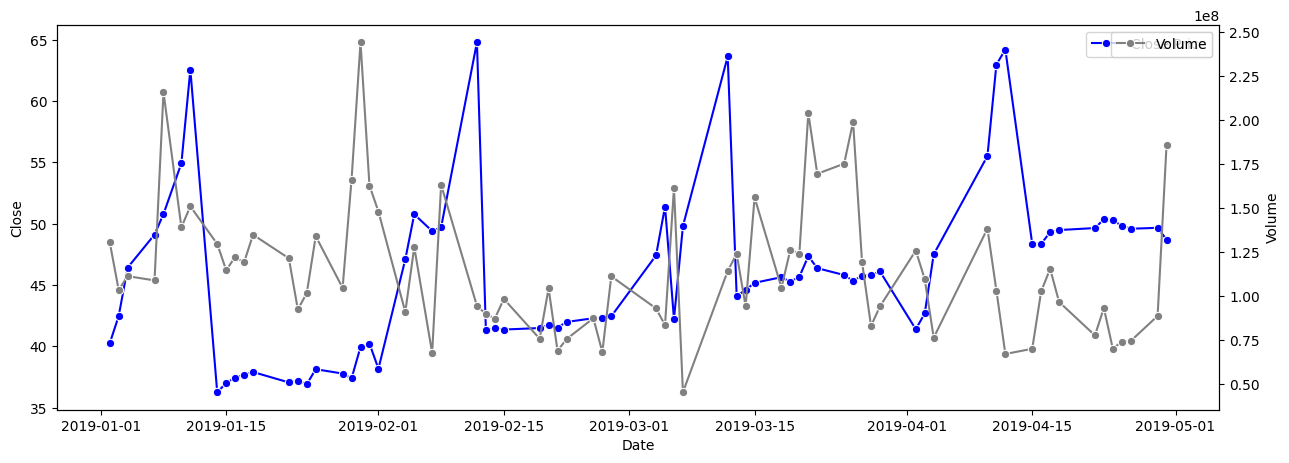

In [31]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(15,5))

# Lineplot on primary y-axis
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Close', ax=ax1, color='blue', marker='o', label='Close Price')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Lineplot on secondary y-axis
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Volume', ax=ax2, color='gray', marker='o', label='Volume')

ax1.legend(bbox_to_anchor=(1,1));

## **Data Preprocessing**

In [32]:
stock["Date"].describe() #Complete the code to print the statistical summary of the 'Date' column

,Date
count,349
mean,2019-02-16 16:05:30.085959936
min,2019-01-02 00:00:00
25%,2019-01-14 00:00:00
50%,2019-02-05 00:00:00
75%,2019-03-22 00:00:00
max,2019-04-30 00:00:00


### Train-test-validation Split

In [33]:
X_train = stock[(stock['Date'] < '2019-04-01')].reset_index()    #Complete the code to select all rows where the 'Date' is before '2019-04-01'
X_val = stock[(stock['Date'] >= '2019-04-01') & (stock['Date'] < '2019-04-16')].reset_index()    #Complete the code to select all rows where the 'Date' is from '2019-04-01 to '2019-04-16' (excluded)
X_test = stock[stock['Date'] >= '2019-04-16'].reset_index()    #Complete the code to select all rows where the 'Date' is from '2019-04-16' till the end.

In [34]:
# Complete the code to pick the 'Label' column as the target variable
y_train = X_train["Label"].copy()
y_val = X_val["Label"].copy()
y_test = X_test["Label"].copy()

In [35]:
#Complete the code to print the shape of X_train,X_val,X_test,y_train,y_val and y_test
print("Train data shape",X_train.shape)
print("Validation data shape",X_val.shape)
print("Test data shape ",X_test.shape)

print("Train label shape",y_train.shape)
print("Validation label shape",y_val.shape)
print("Test label shape ",y_test.shape)

Train data shape (286, 10)
Validation data shape (21, 10)
Test data shape  (42, 10)
Train label shape (286,)
Validation label shape (21,)
Test label shape  (42,)


## **Word Embeddings**

### Word2Vec

In [36]:
# Creating a list of all words in our data
words_list = [item.split(" ") for item in stock['News'].values]

In [37]:
# Creating an instance of Word2Vec
vec_size = 300
model_W2V = Word2Vec(words_list, vector_size = vec_size, min_count = 1, window=5, workers = 6)

In [38]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(list(model_W2V.wv.key_to_index)))

Length of the vocabulary is 4682


Let's check out a few word embeddings obtained using the model.

In [39]:
# Checking the word embedding of a random word
word = "stock"
model_W2V.wv[word]

array([-4.29177610e-03,  3.77081893e-02,  8.24028347e-03,  1.16009284e-02,
        1.34696963e-03, -5.74097969e-02,  2.88146362e-02,  8.76685828e-02,
        3.86525528e-03, -2.20471434e-02,  6.07210118e-03, -2.09048670e-02,
       -4.77102818e-03,  1.50606493e-02, -2.56194454e-02, -2.71958783e-02,
        2.31667664e-02, -4.16548597e-03,  6.68178545e-03, -2.48165745e-02,
       -2.29191314e-02,  7.99265970e-03,  2.94337608e-02,  1.49688479e-02,
        2.43536085e-02,  6.18507212e-04, -3.56254838e-02,  8.63437820e-03,
       -2.86918990e-02, -4.12386134e-02,  1.00202337e-02, -2.73756925e-02,
        4.87250881e-03, -8.76003876e-03, -1.66004116e-03,  2.32866388e-02,
        1.24629466e-02, -3.43374833e-02, -2.57648015e-03, -1.23167001e-02,
       -2.01371610e-02,  3.77025851e-03, -1.32987116e-04, -2.07560584e-02,
        2.00124457e-02,  3.80986780e-02,  8.85568466e-03,  1.77277382e-02,
        2.05466989e-04,  2.34900210e-02,  1.19869532e-02, -9.26989596e-03,
       -2.07764897e-02,  

In [40]:
# Checking the word embedding of a random word
word = "economy"
model_W2V.wv[word]

array([-1.19400327e-03,  5.22621162e-03,  3.23029561e-03,  1.91915862e-03,
       -1.11150509e-03, -1.14132529e-02,  6.69721281e-03,  1.56215653e-02,
       -1.96088385e-03, -2.19317502e-03, -2.42762826e-03, -3.47821484e-03,
        7.76084897e-04, -2.78431922e-04, -4.22875863e-03, -1.78844761e-03,
        7.23573845e-03,  1.88217254e-03,  3.73451505e-03, -2.70680827e-03,
       -5.80710173e-03,  2.80384556e-03,  3.93585069e-03, -8.21259338e-04,
        1.24589168e-03, -1.22571818e-03, -7.14523112e-03,  2.28408142e-03,
       -6.63018692e-03, -9.67126805e-03, -1.97811471e-03, -6.56726724e-03,
        2.94052507e-03, -2.69187172e-03, -2.66357837e-03,  5.90324402e-03,
       -1.59581643e-04, -5.38239349e-03, -7.17772928e-05, -2.94485525e-03,
       -5.76717220e-03,  8.02605064e-04,  1.41059642e-03, -3.90892196e-03,
        3.92873399e-03,  3.83977778e-03, -6.07959810e-04,  1.12823769e-03,
       -2.22633935e-05,  1.03145640e-03,  4.67873551e-03, -4.15836601e-03,
       -4.09972062e-03,  

In [41]:
# Retrieving the words present in the Word2Vec model's vocabulary
words = list(model_W2V.wv.key_to_index.keys())

# Retrieving word vectors for all the words present in the model's vocabulary
wvs = model_W2V.wv[words].tolist()

# Creating a dictionary of words and their corresponding vectors
word_vector_dict = dict(zip(words, wvs))

In [42]:
def average_vectorizer_Word2Vec(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [43]:
# creating a dataframe of the vectorized documents
start = time.time()

X_train_wv = pd.DataFrame(X_train["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_val_wv = pd.DataFrame(X_val["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_wv = pd.DataFrame(X_test["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

end = time.time()
print('Time taken ', (end-start))

Time taken  0.4555084705352783


In [44]:
print(X_train_wv.shape, X_val_wv.shape, X_test_wv.shape)

(286, 300) (21, 300) (42, 300)


### GloVe

In [45]:
import numpy as np

def load_glove_model(filename):
    print("Loading GloVe Model")
    glove_model = {}
    with open(filename,'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

filename = 'glove.6B.100d.txt.word2vec'
glove_model = load_glove_model(filename)

Loading GloVe Model
400001 words loaded!


In [46]:
# load the Stanford GloVe model
filename = 'glove.6B.100d.txt.word2vec'
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [47]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(glove_model.index_to_key))

Length of the vocabulary is 400000


Let's check out a few word embeddings.

In [48]:
# Checking the word embedding of a random word
word = "stock"
glove_model[word]

array([ 8.6341e-01,  6.9648e-01,  4.5794e-02, -9.5708e-03, -2.5498e-01,
       -7.4666e-01, -2.2086e-01, -4.4615e-01, -1.0423e-01, -9.9931e-01,
        7.2550e-02,  4.5049e-01, -5.9912e-02, -5.7837e-01, -4.6540e-01,
        4.3429e-02, -5.0570e-01, -1.5442e-01,  9.8250e-01, -8.1571e-02,
        2.6523e-01, -2.3734e-01,  9.7675e-02,  5.8588e-01, -1.2948e-01,
       -6.8956e-01, -1.2811e-01, -5.2265e-02, -6.7719e-01,  3.0190e-02,
        1.8058e-01,  8.6121e-01, -8.3206e-01, -5.6887e-02, -2.9578e-01,
        4.7180e-01,  1.2811e+00, -2.5228e-01,  4.9557e-02, -7.2455e-01,
        6.6758e-01, -1.1091e+00, -2.0493e-01, -5.8669e-01, -2.5375e-03,
        8.2777e-01, -4.9102e-01, -2.6475e-01,  4.3015e-01, -2.0516e+00,
       -3.3208e-01,  5.1845e-02,  5.2646e-01,  8.7452e-01, -9.0237e-01,
       -1.7366e+00, -3.4727e-01,  1.6590e-01,  2.7727e+00,  6.5756e-02,
       -4.0363e-01,  3.8252e-01, -3.0787e-01,  5.9202e-01,  1.3468e-01,
       -3.3851e-01,  3.3646e-01,  2.0950e-01,  8.5905e-01,  5.18

In [49]:
# Checking the word embedding of a random word
word = "economy"
glove_model[word]

array([-0.19382  ,  1.017    ,  1.076    ,  0.02954  , -0.39192  ,
       -1.3891   , -0.87873  , -0.63162  ,  0.9643   , -0.43035  ,
       -0.34868  ,  0.22736  , -0.40296  ,  0.15641  , -0.16813  ,
       -0.15343  , -0.15799  , -0.27612  ,  0.18088  , -0.28386  ,
        0.49847  ,  0.29864  ,  0.32353  ,  0.18108  , -0.59623  ,
       -0.54165  , -0.70019  , -0.64956  , -0.69063  ,  0.18084  ,
       -0.38581  ,  0.56086  , -0.40313  , -0.38777  , -0.70615  ,
        0.20657  ,  0.34171  , -0.23393  , -0.35882  , -0.2201   ,
       -0.76182  , -1.2047   ,  0.4339   ,  1.1656   ,  0.1836   ,
       -0.21601  ,  0.93198  , -0.059616 , -0.11624  , -1.3259   ,
       -0.79772  , -0.0074957, -0.0889   ,  1.4749   ,  0.31157  ,
       -2.2952   , -0.058351 ,  0.39353  ,  1.4983   ,  0.74023  ,
       -0.20109  ,  0.098124 , -0.73081  , -0.32294  ,  0.16703  ,
        0.87431  , -0.041624 , -0.51022  ,  1.0737   , -0.4257   ,
        1.0581   ,  0.19859  , -0.60087  , -0.33906  ,  0.6024

In [50]:
# Retrieving the words present in the GloVe model's vocabulary
glove_words = glove_model.index_to_key

# Creating a dictionary of words and their corresponding vectors
glove_word_vector_dict = dict(zip(glove_model.index_to_key,list(glove_model.vectors)))

In [51]:
vec_size=100

In [52]:
def average_vectorizer_GloVe(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in glove_words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(glove_word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [53]:
# creating a dataframe of the vectorized documents
start = time.time()

X_train_gl = pd.DataFrame(X_train["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)]) #Complete the code to apply GloVe on 'News' column
X_val_gl = pd.DataFrame(X_val["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)]) #Complete the code to apply GloVe on 'News' column
X_test_gl = pd.DataFrame(X_test["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)]) #Complete the code to apply GloVe on 'News' column

end = time.time()
print('Time taken ', (end-start))

Time taken  29.821874856948853


In [54]:
print(X_train_gl.shape, X_val_gl.shape, X_test_gl.shape) #Complete the code to print the shapes of the final dataframes

(286, 100) (21, 100) (42, 100)


### Sentence Transformer

#### Defining the model

In [55]:
#Defining the model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

#### Encoding the dataset

In [56]:
# setting the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [57]:
# encoding the dataset
start = time.time()

X_train_st = model.encode(X_train["News"].values, show_progress_bar=True, device=device) #Complete the code to apply Sentence Transformer on 'News' column
X_val_st = model.encode(X_val["News"].values, show_progress_bar=True, device=device) #Complete the code to apply Sentence Transformer on 'News' column
X_test_st = model.encode(X_test["News"].values, show_progress_bar=True, device=device) #Complete the code to apply Sentence Transformer on 'News' column

end = time.time()
print("Time taken ",(end-start))

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Time taken  1.1318418979644775


In [58]:
print(X_train_st.shape, X_val_st.shape, X_test_st.shape) #Complete the code to print the shapes of the final dataframes

(286, 384) (21, 384) (42, 384)


- Each news content has been converted to a 384-dimensional vector.

## **Sentiment Analysis**

### Model Evaluation Criterion

-


### Utility Functions

In [59]:
def plot_confusion_matrix(model, predictors, target):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
    actual (array-like): The true labels.
    predicted (array-like): The predicted labels from the model.

    Returns:
    None: Displays the confusion matrix plot.
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    cm = confusion_matrix(target, pred)  # Compute the confusion matrix.

    plt.figure(figsize=(5, 4))  # Create a new figure with a specified size.
    label_list = [0, 1,-1]  # Define the labels for the confusion matrix.
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
    # Plot the confusion matrix using a heatmap with annotations.

    plt.ylabel('Actual')  # Label for the y-axis.
    plt.xlabel('Predicted')  # Label for the x-axis.
    plt.title('Confusion Matrix')  # Title of the plot.
    plt.show()  # Display the plot.

In [60]:
def model_performance_classification_sklearn(model, predictors, target):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    model (sklearn classifier): The classification model to evaluate.
    predictors (array-like): The independent variables used for predictions.
    target (array-like): The true labels for the dependent variable.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score).
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    acc = accuracy_score(target, pred)  # Compute Accuracy.
    recall = recall_score(target, pred,average='weighted')  # Compute Recall.
    precision = precision_score(target, pred,average='weighted')  # Compute Precision.
    f1 = f1_score(target, pred,average='weighted')  # Compute F1-score.

    # Create a DataFrame to store the computed metrics.
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )

    return df_perf  # Return the DataFrame with the metrics.

### Base Model - Word2Vec

In [61]:
# Building the model

#Uncomment only one of the snippets related to fitting the model to the data

base_wv = GradientBoostingClassifier(random_state = 42)
#base_wv = RandomForestClassifier(random_state=42)
#base_wv = DecisionTreeClassifier(random_state=42)

# Fitting on train data
base_wv.fit(X_train_wv, y_train)

GradientBoostingClassifier(random_state=42)

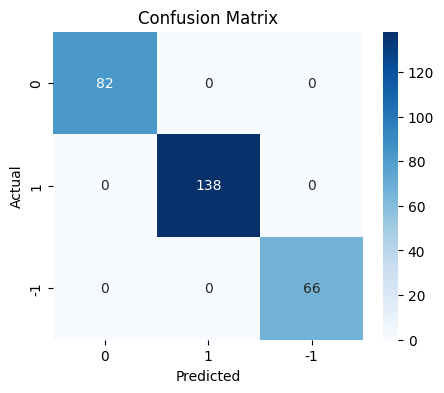

In [62]:
plot_confusion_matrix(base_wv,X_train_wv,y_train)

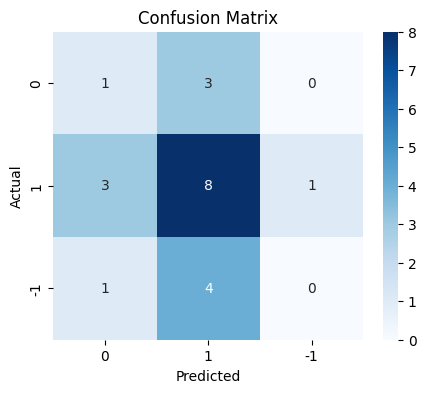

In [63]:
plot_confusion_matrix(base_wv,X_val_wv,y_val)

In [64]:
#Calculating different metrics on training data
base_train_wv = model_performance_classification_sklearn(base_wv,X_train_wv,y_train)
print("Training performance:\n", base_train_wv)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [65]:
#Calculating different metrics on validation data
base_val_wv = model_performance_classification_sklearn(base_wv,X_val_wv,y_val)
print("Validation performance:\n",base_val_wv)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.428571  0.428571   0.342857  0.380952


### Base Model - GloVe

In [67]:
#Building the model

#Uncomment only one of the snippets related to fitting the model to the data

base_gl = GradientBoostingClassifier(random_state = 42)
#base_wv = RandomForestClassifier(random_state=42)
#base_wv = DecisionTreeClassifier(random_state=42)

# Fitting on train data
base_gl.fit(X_train_gl, y_train) #Complete the code to fit the chosen model on the train data

GradientBoostingClassifier(random_state=42)

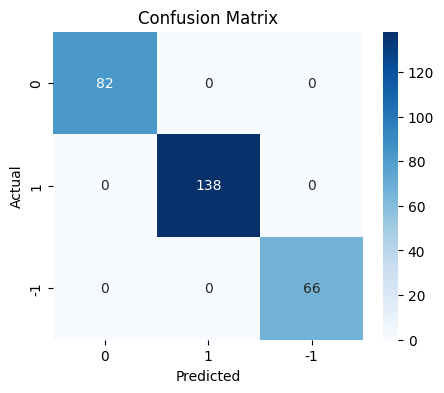

In [68]:
plot_confusion_matrix(base_gl,X_train_gl,y_train) #Complete the code to plot the confusion matrix for the train data

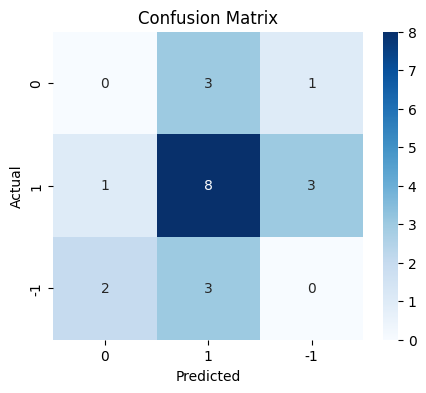

In [69]:
plot_confusion_matrix(base_gl,X_val_gl,y_val) #Complete the code to plot the confusion matrix for the validation data

In [73]:
#Calculating different metrics on training data
base_train_gl=model_performance_classification_sklearn(base_gl,X_val_gl,y_val) #Complete the code to compute the model performance for the training data
print("Training performance:\n", base_train_gl)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.380952  0.380952   0.326531  0.351648


In [83]:
#Calculating different metrics on validation data
base_val_gl = model_performance_classification_sklearn(base_gl,X_val_gl,y_val) #Complete the code to compute the model performance for the validation data
print("Validation performance:\n",base_val_gl)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.380952  0.380952   0.326531  0.351648


### Base Model - Sentence Transformer

In [75]:
# Building the model

#Uncomment only one of the snippets related to fitting the model to the data

base_st = GradientBoostingClassifier(random_state = 42)
#base_wv = RandomForestClassifier(random_state=42)
#base_wv = DecisionTreeClassifier(random_state=42)

# Fitting on train data
base_st.fit(X_train_st, y_train) #Complete the code to fit the chosen model on the train data

GradientBoostingClassifier(random_state=42)

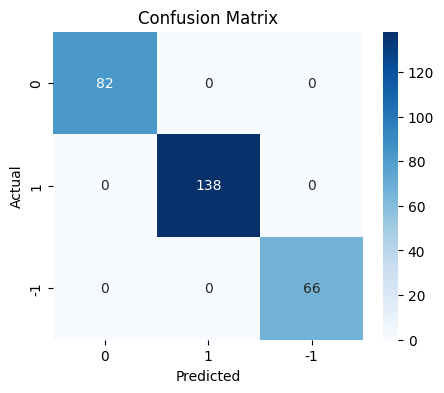

In [77]:
plot_confusion_matrix(base_st,X_train_st,y_train) #Complete the code to plot the confusion matrix for the train data

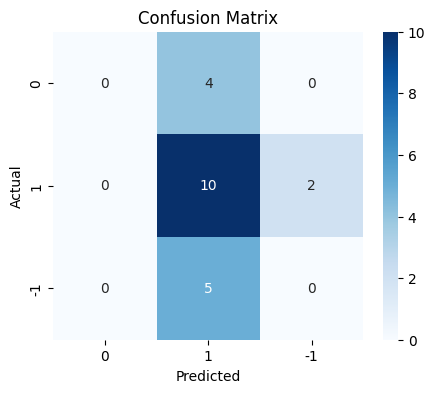

In [78]:
plot_confusion_matrix(base_st,X_val_st,y_val) #Complete the code to plot the confusion matrix for the validation data

In [79]:
#Calculating different metrics on training data
base_train_st=model_performance_classification_sklearn(base_st,X_train_st,y_train) #Complete the code to compute the model performance for the training data
print("Training performance:\n", base_train_st)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [80]:
#Calculating different metrics on validation data
base_val_st = model_performance_classification_sklearn(base_st,X_val_st,y_val) #Complete the code to compute the model performance for the validation data
print("Validation performance:\n",base_val_st)

Validation performance:
    Accuracy   Recall  Precision        F1
0   0.47619  0.47619   0.300752  0.368664


### Tuned Model - Word2Vec

**Note**: The parameter grid provided below is a sample grid. It can be modified depending on the compute power of the system being used.

In [84]:
start = time.time()

# Choose the type of classifier.

#Uncomment only one of the snippets corrrsponding to the base model trained previously

tuned_wv = GradientBoostingClassifier(random_state = 42)
#tuned_wv = RandomForestClassifier(random_state=42)
#tuned_wv = DecisionTreeClassifier(random_state=42)


parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_wv, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_wv, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_wv = grid_obj.best_estimator_

Time taken  516.799708366394


In [85]:
# Fit the best algorithm to the data.
tuned_wv.fit(X_train_wv, y_train)

GradientBoostingClassifier(max_depth=5, max_features='sqrt',
                           min_samples_split=7, random_state=42)

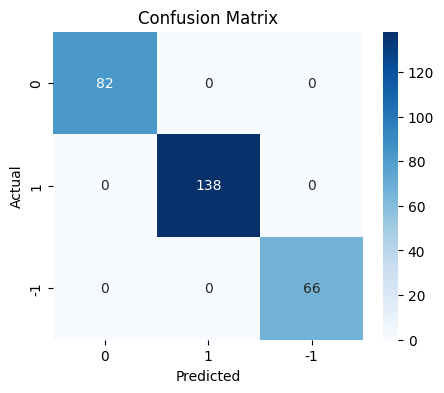

In [86]:
plot_confusion_matrix(tuned_wv,X_train_wv,y_train)

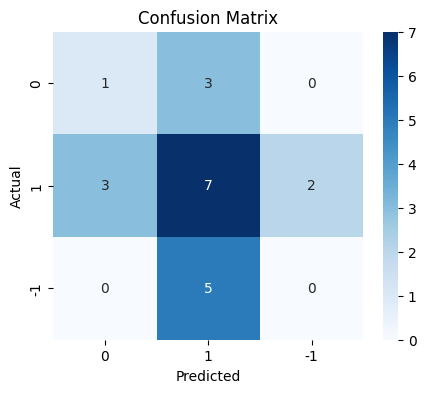

In [87]:
plot_confusion_matrix(tuned_wv,X_val_wv,y_val)

In [88]:
#Calculating different metrics on training data
tuned_train_wv=model_performance_classification_sklearn(tuned_wv,X_train_wv,y_train)
print("Training performance:\n",tuned_train_wv)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [89]:
#Calculating different metrics on validation data
tuned_val_wv = model_performance_classification_sklearn(tuned_wv,X_val_wv,y_val)
print("Validation performance:\n",tuned_val_wv)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.380952  0.380952   0.314286  0.343915


### Tuned Model - GloVe

In [91]:
start = time.time()

#Uncomment only one of the snippets corrrsponding to the base model trained previously

tuned_gl = GradientBoostingClassifier(random_state = 42)
#tuned_wv = RandomForestClassifier(random_state=42)
#tuned_wv = DecisionTreeClassifier(random_state=42)

parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_gl, parameters, scoring='f1_weighted',cv=5,n_jobs=-1) #Complete the code to pass the chosen model
grid_obj = grid_obj.fit(X_train_gl, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_gl = grid_obj.best_estimator_

Time taken  273.4801969528198


In [92]:
# Fit the best algorithm to the data.
tuned_gl.fit(X_train_gl, y_train) #Complete the code to fit the chosen model on the train data

GradientBoostingClassifier(max_features='log2', min_samples_split=9,
                           random_state=42)

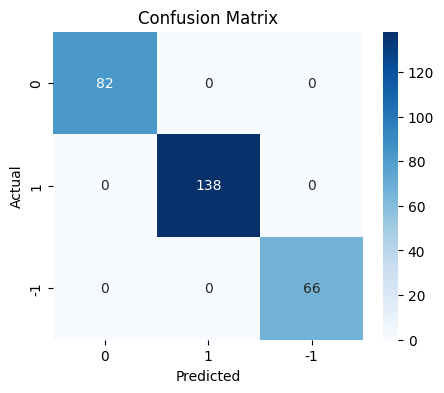

In [93]:
plot_confusion_matrix(tuned_gl,X_train_gl,y_train) #Complete the code to plot the confusion matrix for the train data

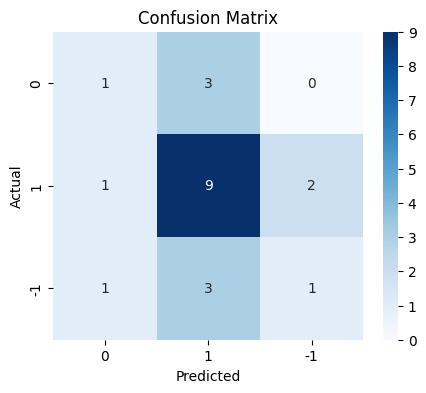

In [94]:
plot_confusion_matrix(tuned_gl,X_val_gl,y_val) #Complete the code to plot the confusion matrix for the validation data

In [95]:
#Calculating different metrics on training data
tuned_train_gl=model_performance_classification_sklearn(tuned_gl,X_train_gl,y_train) #Complete the code to compute the model performance for the training data
print("Training performance:\n",tuned_train_gl)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [96]:
#Calculating different metrics on validation data
tuned_val_gl = model_performance_classification_sklearn(tuned_gl,X_val_gl,y_val) #Complete the code to compute the model performance for the validation data
print("Validation performance:\n",tuned_val_gl)

Validation performance:
    Accuracy   Recall  Precision        F1
0   0.52381  0.52381   0.485714  0.494898


### Tuned Model - Sentence Transformer

In [98]:
start = time.time()

# Choose the type of classifier.

#Uncomment only one of the snippets corrrsponding to the base model trained previously

tuned_st = GradientBoostingClassifier(random_state = 42)
#tuned_wv = RandomForestClassifier(random_state=42)
#tuned_wv = DecisionTreeClassifier(random_state=42)

parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_st, parameters, scoring='f1_weighted',cv=5,n_jobs=-1) #Complete the code to pass the chosen model
grid_obj = grid_obj.fit(X_train_st, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_st = grid_obj.best_estimator_

Time taken  647.0285594463348


In [99]:
# Fit the best algorithm to the data.
tuned_st.fit(X_train_st, y_train) #Complete the code to fit the chosen model on the train data

GradientBoostingClassifier(max_depth=6, max_features=0.4, min_samples_split=9,
                           random_state=42)

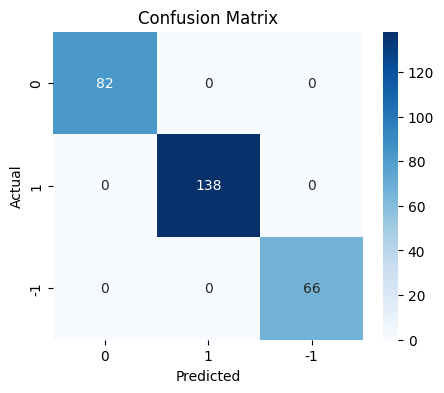

In [100]:
plot_confusion_matrix(tuned_st,X_train_st,y_train) #Complete the code to plot the confusion matrix for the train data

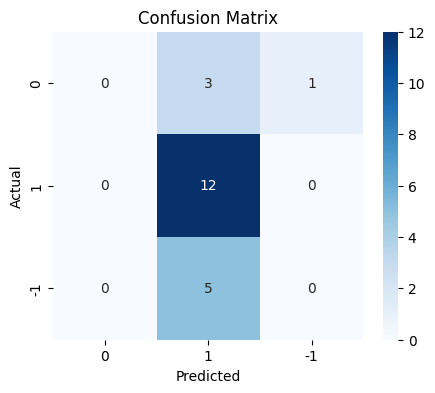

In [131]:
plot_confusion_matrix(tuned_st,X_val_st,y_val) #Complete the code to plot the confusion matrix for the validation data

In [132]:
#Calculating different metrics on training data
tuned_train_st=model_performance_classification_sklearn(tuned_st,X_train_st,y_train) #Complete the code to compute the model performance for the training data
print("Training performance:\n",tuned_train_st)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [133]:
#Calculating different metrics on validation data
tuned_val_st = model_performance_classification_sklearn(tuned_st,X_val_st,y_val) #Complete the code to compute the model performance for the validation data
print("Validation performance:\n",tuned_val_st)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.571429  0.571429   0.342857  0.428571


### Model Performance Summary and Final Model Selection

In [134]:
#training performance comparison

models_train_comp_df = pd.concat(
    [base_train_wv.T,
     base_train_gl.T,
     base_train_st.T,
     tuned_train_wv.T,
     tuned_train_gl.T,
     tuned_train_st.T,
    ],axis=1
)

models_train_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Base Model (Word2Vec),Base Model (GloVe),Base Model (Sentence Transformer),Tuned Model (Word2Vec),Tuned Model (GloVe),Tuned Model (Sentence Transformer)
Accuracy,1.0,0.380952,1.0,1.0,1.0,1.0
Recall,1.0,0.380952,1.0,1.0,1.0,1.0
Precision,1.0,0.326531,1.0,1.0,1.0,1.0
F1,1.0,0.351648,1.0,1.0,1.0,1.0


In [135]:
#validation performance comparison

models_val_comp_df = pd.concat(
    [base_val_wv.T,
     base_val_gl.T,
     base_val_st.T,
     tuned_val_wv.T,
     tuned_val_gl.T,
     tuned_val_st.T,
     ],axis=1
)

models_val_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,Base Model (Word2Vec),Base Model (GloVe),Base Model (Sentence Transformer),Tuned Model (Word2Vec),Tuned Model (GloVe),Tuned Model (Sentence Transformer)
Accuracy,0.428571,0.380952,0.476190,0.380952,0.523810,0.571429
Recall,0.428571,0.380952,0.476190,0.380952,0.523810,0.571429
Precision,0.342857,0.326531,0.300752,0.314286,0.485714,0.342857
F1,0.380952,0.351648,0.368664,0.343915,0.494898,0.428571


### Model Performance Check on Test Data

In [136]:
final_model = tuned_st

plot_confusion_matrix(final_model,X_test,y_test) #Complete the code to plot the confusion matrix for the final model and test data

TypeError: float() argument must be a string or a real number, not 'Timestamp'

In [137]:
#Calculating different metrics on training data
final_model_test = model_performance_classification_sklearn(final_model,X_test,y_test) #Complete the code to compute the final model's performance for the test data
print("Test performance for the final model:\n",final_model_test_test)

TypeError: float() argument must be a string or a real number, not 'Timestamp'

## **Weekly News Summarization**

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries

In [45]:
# Installation for GPU llama-cpp-python
# uncomment and run the following code in case GPU is being used
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.85 --force-reinstall --no-cache-dir -q

# Installation for CPU llama-cpp-python
# uncomment and run the following code in case GPU is not being used
#!CMAKE_ARGS="-DLLAMA_CUBLAS=off" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.85 --force-reinstall --no-cache-dir -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 136.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 127.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 248.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 253.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.3 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.3 which is incompatible.
thinc 8.2.5 requires numpy<2.0.0,>=1.19.0; python_version >= "3.9", but you have numpy 2.2.3 which is incompatible.
numba 0.61.0 requires numpy<2.2,>=1.24, but you have numpy 2.2.3 

In [46]:
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

# Importing the library for data manipulation
import pandas as pd

from tqdm import tqdm # For progress bar related functionalities
tqdm.pandas()

#### Loading the data

In [47]:
stock_news = pd.read_csv("stock_news.csv") #Complete the code to load the dataset

In [48]:
data = stock_news.copy()

#### Loading the model

In [49]:
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_basename = "mistral-7b-instruct-v0.2.Q6_K.gguf"


model_path = hf_hub_download(
    repo_id=model_name_or_path, # Complete the code to mention the repo_id
    filename=model_basename # Complete the code to mention the filename
)

mistral-7b-instruct-v0.2.Q6_K.gguf:   0%|          | 0.00/5.94G [00:00<?, ?B/s]

In [64]:
#uncomment the below snippet of code if the runtime is connected to GPU.
llm = Llama(
    model_path=model_path, # Path to the model
    n_gpu_layers=100, #Number of layers transferred to GPU
    n_ctx=4500, #Context window
)

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 


In [ ]:
# uncomment and run the following code in case GPU is not being used

# llm = Llama(
#     model_path=model_path,
#     n_ctx=4500, # Context window
#     n_cores=-2 # Number of CPU cores to use
# )

#### Aggregating the data weekly

In [65]:
data["Date"] = pd.to_datetime(data['Date'])  # Convert the 'Date' column to datetime format.

In [66]:
# Group the data by week using the 'Date' column.
weekly_grouped = data.groupby(pd.Grouper(key='Date', freq='W'))

In [67]:
# Aggregate the grouped data on a weekly basis:
# concatenate 'content' values into a single string separated by ' || '.
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()

print(weekly_grouped.shape)

(18, 2)


In [68]:
weekly_grouped

,Date,News
0,2019-01-06,The tech sector experienced a significant dec...
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...
2,2019-01-20,The U.S. stock market declined on Monday as c...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre..."
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...
5,2019-02-10,"The Dow Jones Industrial Average, S&P 500, an..."
6,2019-02-17,"This week, the European Union's second highes..."
7,2019-02-24,This news article discusses progress towards ...
8,2019-03-03,The Dow Jones Industrial Average and other ma...
9,2019-03-10,"Spotify, the world's largest paid music strea..."


In [69]:
# creating a copy of the data
data_1 = weekly_grouped.copy()

#### Summarization

**Note**:

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

For the project, we need to define the prompt to be fed to the LLM to help it understand the task to perform. The following should be the components of the prompt:

1. **Role**: Specifies the role the LLM will be taking up to perform the specified task, along with any specific details regarding the role

  - **Example**: `You are an expert data analyst specializing in news content analysis.`

2. **Task**: Specifies the task to be performed and outlines what needs to be accomplished, clearly defining the objective

  - **Example**: `Analyze the provided news headline and return the main topics contained within it.`

3. **Instructions**: Provides detailed guidelines on how to perform the task, which includes steps, rules, and criteria to ensure the task is executed correctly

  - **Example**:

```
Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.
```

4. **Output Format**: Specifies the format in which the final response should be structured, ensuring consistency and clarity in the generated output

  - **Example**: `Return the output in JSON format with keys as the topic number and values as the actual topic.`

**Full Prompt Example**:

```
You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and return the main topics contained within it.

Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.

Return the output in JSON format with keys as the topic number and values as the actual topic.
```

**Sample Output**:

`{"1": "Politics", "2": "Economy", "3": "Health" }`

##### Utility Functions

In [70]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

##### Defining the response function

In [71]:
#Defining the response function
def response_mistral_1(prompt, news):
    model_output = llm(
      f"""
      [INST]
      {prompt}
      News Articles: {news}
      [/INST]
      """,
      max_tokens=512, #Complete the code to set the maximum number of tokens the model should generate for this task.
      temperature=0.7, #Complete the code to set the value for temperature.
      top_p=0.9, #Complete the code to set the value for top_p
      top_k=50, #Complete the code to set the value for top_k
      echo=False,
    )

    final_output = model_output["choices"][0]["text"]

    return final_output

##### Checking the model output on a sample

In [72]:
news = data_1.loc[0, 'News']

In [73]:
print(len(news.split(' ')))
news

2611


' The tech sector experienced a significant decline in the aftermarket following Apple\'s Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple\'s downward revision of its revenue expectations for the quarter, previously announced in January. ||  Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple\'s stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10 ||  Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple\'s shares fell 8.5% in post market trading, while Asian suppliers like Hon ||  This news article reports that yields o

In [74]:
#Complete the code to define the prompt for this task
prompt = """
    You are a financial news analyst specializing in identifying key events that impact stock market movements.

### **Task:**
Analyze the given financial news articles for the week and extract the top **three positive** and **three negative** events that could influence stock prices.

### **Instructions:**
1. **Read** all the provided news articles carefully.
2. **Identify** the most significant events that have potential financial impact.
3. **Categorize** events into **positive** (likely to boost stock prices) and **negative** (likely to cause stock decline).
4. **Rank** the top **three** most impactful positive and negative events.
5. **Ensure** the events are **specific** and **concise**.

### **Output Format:**
Return a JSON object with two main keys:
- `"Positive Events"`: A list containing the top 3 positive stock-influencing events.
- `"Negative Events"`: A list containing the top 3 negative stock-influencing events.

### **Example Output:**
```json
{
  "Positive Events": [
    "Company A reports record quarterly profits, exceeding analyst expectations.",
    "Government announces economic stimulus package boosting market confidence.",
    "Tech company B secures $1B funding for AI innovation, driving stock rally."
  ],
  "Negative Events": [
    "Regulatory investigation launched against major financial institution.",
    "Global oil prices surge 10%, raising inflation concerns.",
    "Company C announces unexpected layoffs, causing investor panic."
  ]
}
"""

In [75]:
%%time
summary = response_mistral_1(prompt, news)
print(summary)

 Based on the given news articles, here are the top three positive and negative events that could influence stock prices:

      **Positive Events:**
      1. Roku Inc announces plans to offer premium video channels on a subscription basis through its free streaming service, The Roku Channel. (Article 7)
      2. Gold prices reach over six-month highs due to investor concerns over a global economic slowdown and stock market volatility. (Article 15)
      3. U.S.-China trade talks resume with deputy U.S. Trade Representative Jeffrey Gerrish leading the U.S. delegation for negotiations on Jan. 7 and 8, 2019. (Article 34)

      **Negative Events:**
      1. Apple cut its quarterly revenue forecast for the first time in over 15 years due to weak iPhone sales in China, representing around 20% of Apple's revenue. (Article 36)
      2. Goldman analyst Rod Hall lowered his price target for Apple from $182 to $140, citing potential risks to the tech giant's 2019 numbers due to uncertainties in

##### Checking the model output on the weekly data

In [76]:
%%time
data_1['Key Events'] = data_1['News'].progress_apply(lambda x: response_mistral_1(prompt,x))

100%|██████████| 18/18 [05:00<00:00, 16.72s/it]

CPU times: user 4min 33s, sys: 25.6 s, total: 4min 59s
Wall time: 5min


In [77]:
data_1["Key Events"].head() #Complete the code to print the first 5 rows of the 'Key_Events' column

,Key Events
0,"Based on the provided news articles, here are ..."
1,"{\n ""Positive Events"": [\n ..."
2,"{\n ""Positive Events"": [\n ""D..."
3,"{\n ""Positive Events"": [\n ""I..."
4,"{\n ""Positive Events"": [\n ..."


##### Formatting the model output

In [78]:
data_1['model_response_parsed'] = data_1['Key Events'].apply(extract_json_data)
data_1.head()


### Positive Events:
1. "Roku Inc announces plans to offer premium video channels on a subscription basis through its free streaming service, The Roku Channel."
2. "The Chinese central bank announces a fifth reduction in the required reserve ratio (RRR) for banks, freeing up approximately 116.5 billion yuan for new lending."
3. "Apple CEO Tim Cook maintains a bullish stance on Apple, keeping its Outperform rating and $220 price target, despite concerns over iPhone demand."

### Negative Events:
1. "Apple lowers its fiscal Q1 revenue forecast from $89-$93 billion to $84 billion due to weak iPhone sales and upgrades, as well as weakness in emerging markets."
2. "Global oil prices surge 10%, raising inflation concerns and negatively impacting energy stocks."
3. "Regulatory investigation launched against Qualcomm for patent infringement, potentially leading to legal fees and reputational damage."

These events are significant, specific, and concise, and should provide valuable insights in

,Date,News,Key Events,model_response_parsed
0,2019-01-06,The tech sector experienced a significant dec...,"Based on the provided news articles, here are ...",{}
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...,"{\n ""Positive Events"": [\n ...",{'Positive Events': ['AMS develops new 3D faci...
2,2019-01-20,The U.S. stock market declined on Monday as c...,"{\n ""Positive Events"": [\n ""D...",{'Positive Events': ['Dialog Semiconductor rep...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre...","{\n ""Positive Events"": [\n ""I...",{'Positive Events': ['IBM reports better-than-...
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...,"{\n ""Positive Events"": [\n ...",{'Positive Events': ['Apple reports stronger-t...


ValueError: 
 Caterpillar Inc reported lower-than-expected fourth quarter earnings and full year 2019 outlook due to weak demand in China's construction business. The company's shares fell by 5%, pulling down U.S. stock futures. Despite attempts to ease investor concerns during the October earnings call, recent ||  Apple reported spending over $60 billion with around 9,000 U.S. component suppliers and companies in 2018, marking a more than 10% increase from the previous year. Since 2011, Apple has generated or supported over 2 million jobs across all 50 states in ||  Apple is expected to report lower-than-projected fiscal first quarter earnings, with revenue falling significantly due to disappointing iPhone sales in China. This follows China's emergence as a major challenge for Apple due to trade tensions and competition from lower-priced smartphones from competitors like Huawei, Samsung, and others. Harley ||  In 2018, China's smartphone shipments declined 14% YoY to 396 million units, with Q4 experiencing a 15% YoY drop and seven consecutive quarters of decline. Huawei and Vivo were the only top five vendors to experience growth in 201 ||  Gold hit a seven-month high on Tuesday, as investors sought safety amid upcoming major macro events, including Brexit votes, US Federal Reserve decision, and Sino-US trade talks, as well as tech earnings and weak economic data. The metal broke through $1,300 an ounce due to uncertainties surrounding US- ||  CVS Health's insurer, Aetna, announced a new health app for Apple Watches on Tuesday. The app, called Attain, uses an individual's medical history to set personalized health goals and rewards customers with subsidies or gift cards for meeting them. Aetna had to enter into a business associate agreement to ||  Apple will release a software patch this week to fix a FaceTime bug that lets users hear audio from recipients before they accept video calls. The issue, which can also broadcast video and audio, affects iPhone users and was first reported by Reuters. Apple's group FaceTime service has been temporarily taken offline due to the ongoing problem. ||  Apple, Aetna, and CVS are collaborating on a new health app called Attain. The app offers customized fitness challenges with rewards, including a free Apple Watch Series 3 for participants who don't already own one. Users must meet fitness goals over 24 months to pay off the watch. The companies started developing the ||  Corning defied the trend of weak results in the phone and chip industry, reporting higher-than-expected revenue and profit for Q4. The surge in demand from telecom companies investing in 5G networks led to a 26% increase in sales for its optical communications division, which is on track to exceed its 202 ||  The price of gold reached an eight-month high, driven by anticipation for clues on U.S monetary policy from Federal Reserve Chairman Jerome Powell's news conference. Gold is up 2.4% this year and heading towards a fourth consecutive monthly increase due to prospects of fewer rate hikes and slower global growth amid the ||  In after hours trading, Apple's shares rose despite a rare revenue decline due to weak iPhone sales, particularly in China. The tech giant reported earnings of $4.18 per share, slightly better than expected, but overall revenue was down 4.5%. For the second quarter, Apple anticipates revenue between $55 billion and $ ||  Apple reported stronger-than-expected earnings for Q1 2023, with GAAP EPS coming in at $4.18 versus the estimated $4.17. Revenue surpassed expectations as well, reaching $84.3 billion compared to forecasts of $81 billion, representing a year-over || 3M, the Minnesota-based manufacturing company, issued a revenue warning due to weak demand in China. The slowdown affects its automotive and electronics businesses, causing a reduction in sales growth projections from 2% to 1-4%. This is driven by customer demand issues in China. Other major US companies like Apple and Cater ||  Apple banned Facebook from its business app program after discovering the social media giant was using it to track teenagers' web browsing habits without proper authorization. Facebook's Research app, which collected data via virtual private network software, violated Apple's agreement, leading to Facebook's removal from the program. The ban does not affect Facebook ||  AMD reported in-line earnings but missed revenue estimates, causing shares to surge 16%. Some analysts remain cautious about the company's outlook for the fiscal first quarter due to expected slow growth. Apple reported earnings ahead of estimates, with strong revenue growth from all other products and services, suggesting iPhone sales may have bottomed, eas ||  Google is reportedly operating a research app, Screenwise Meter, which bypasses app store regulations using an Enterprise Certificate. The app invites users to monitor data in exchange for gift cards. Similar actions led Apple to revoke Facebook's certificate, potentially causing disruptions. Google's use of this method could result in Apple rev ||  In Apple's Q1 earnings call, CFO Luca Maestri announced the company is on track to double its FY16 Services revenue by FY20. This growth is attributed to a larger percentage of the installed base paying for at least one service. The Q1 Services margin was 62.8%, higher than ||  Apple's Q4 earnings report showed better-than-expected results, with some weakness already priced in due to the pre-announcement revenue cut. Analysts at Morgan Stanley and JPMorgan remain overweight on the stock, with the latter noting that investor focus should return to the Services opportunity following a downside correction on || The IDC reported a decline in global smartphone shipments for Q4, down 5% YoY to 375.4 million units, marking the fifth consecutive quarter of decreases. Samsung (KS 005930) and Apple (AAPL) led with market shares of 18. ||  LG Display reported stronger profits in Q4 due to increased sales of high-end wearable screens, but warned of weaker panel prices in 2019 amid global economic uncertainty and U.S.-China trade tensions. Operating profit for the quarter was 279 billion won, an increase from 44 billion || European stocks rose on Wednesday as positive news about demand from China outweighed concerns over Brexit. LVMH reported record revenue for 2018, driven by double-digit growth in spending by Chinese customers. The results boosted shares of LVMH and rivals Hermes, Kering, and Burberry. U ||  China's manufacturing sector contracted for the second consecutive month in January, with the official Purchasing Managers Index (PMI) edging up marginally to 49.5 from 49.4 in December. The reading was below the 50 mark that separates growth from contraction. Weakness came from ||  Alibaba, the Chinese e-commerce giant and second most valuable public company in Asia, reported its slowest revenue growth since 2016, totaling 117.3 billion yuan ($17.47 billion) for Q3, missing analyst estimates due to China's slowing economy and trade tensions ||  The Dow Jones Industrial Average, S&P 500, and Nasdaq Composite experienced significant gains on Wednesday due to a dovish Federal Reserve stance and upbeat earnings reports from companies like Apple and Boeing. The Fed indicated it would remain patient in regards to future interest rate adjustments. The tech sector was boosted by ||  Google and Facebook disenabled their research apps, Screenwise Meter for Google and Research App for Facebook, from Apple's developer enterprise program following criticism from privacy experts. The apps were mistakenly distributed through this program instead of the usual app stores. Google apologized for the error. Apple did not comment on the matter. ||  New York authorities are investigating Apple for not warning consumers in a timely manner about a FaceTime bug that allowed iPhone users to hear audio from others' phones before accepting video calls. The probe also covers Apple's slow response, as reports indicate a consumer alerted the company of the issue over a week before the feature was disabled. The bug ||  Apple plans to cut prices of some flagship iPhones to boost sales, particularly in overseas markets like China where the U.S. dollar has risen significantly against local currencies, making Apple's products pricier than rivals. This marks only the second time in iPhone history that prices will be lowered. The move comes after || Didi Chuxing, a Chinese ride-hailing firm backed by Uber, Apple, SoftBank, and others, is considering cutting up to 20% of headcount in some departments, primarily support services like marketing and HR. No final decision has been made. The move comes as part of an organizational overhaul aimed ||  Facebook is facing backlash from Apple following the revelation that the social media giant used a research app to gather user data, in violation of Apple's privacy guidelines. The app, which was distributed under a developer program meant for employee-only apps, paid users up to $20 a month for their data. Apple has revoked Facebook ||  Peter Jackson, the director of "Lord of the Rings," is making a movie about The Beatles using previously unseen studio footage from their final album recording sessions in January 1969. This project marks the 50th anniversary since their last live performance together. Jackson will utilize over 50 hours of never-re ||  Kanye West and Tidal's corporate parent have resolved a lawsuit accusing them of fraudulently inducing fans to subscribe to Tidal by tweeting that his album "The Life of Pablo" could only be obtained there. The plaintiff, Justin Baker Rhett, claimed the tweet was false as the album later ||  The UAE, through a hacking team of American mercenaries, reportedly targeted governments and individuals in rival countries as well as American citizens, according to a Reuters investigation. However, the UAE's Minister of State for Foreign Affairs Anwar Gargash denied targeting friendly countries or American citizens in a cyberprogram called Project || The United Arab Emirates (UAE) denied on Thursday targeting friendly countries or American citizens with its cyberspying program, Project Raven. Reuters reported that the program, which involved a group of American intelligence contractors, targeted governments, dissidents, and human rights activists of rival nations, as well as embassy ||  Apple acknowledged a privacy flaw in its FaceTime chat software that allowed users to hear others before they answered the call. The issue was discovered by a 14-year-old boy and his mother, who faced difficulties in reporting it to Apple for nine days. Apple turned off the group chat feature and promised a fix. New York's governor ||  Foxconn Technology announced on Friday that it will proceed with building a Gen 6 fab facility in Wisconsin, following conversations between its chairman and U.S. President Donald Trump. The $10 billion campus, which was the largest investment for a foreign company in U.S. history when announced in 2017, faced criticism and uncertainty ||  A Chinese court sentenced a Didi Chuxing driver, Zhong Yuan, to death for raping and killing a female passenger last year. The brutal crime sparked public and government criticism of the ride-hailing company, prompting it to suspend its carpool service Hitch and overhaul its business with stricter
                                                                                                                                                                                                                                                                                                                                             ^
ParseException: Expected end of text, found '$'  (at char 333), (line:1, col:334)

from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('News').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Key Events').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

ValueError: 
 Caterpillar Inc reported lower-than-expected fourth quarter earnings and full year 2019 outlook due to weak demand in China's construction business. The company's shares fell by 5%, pulling down U.S. stock futures. Despite attempts to ease investor concerns during the October earnings call, recent ||  Apple reported spending over $60 billion with around 9,000 U.S. component suppliers and companies in 2018, marking a more than 10% increase from the previous year. Since 2011, Apple has generated or supported over 2 million jobs across all 50 states in ||  Apple is expected to report lower-than-projected fiscal first quarter earnings, with revenue falling significantly due to disappointing iPhone sales in China. This follows China's emergence as a major challenge for Apple due to trade tensions and competition from lower-priced smartphones from competitors like Huawei, Samsung, and others. Harley ||  In 2018, China's smartphone shipments declined 14% YoY to 396 million units, with Q4 experiencing a 15% YoY drop and seven consecutive quarters of decline. Huawei and Vivo were the only top five vendors to experience growth in 201 ||  Gold hit a seven-month high on Tuesday, as investors sought safety amid upcoming major macro events, including Brexit votes, US Federal Reserve decision, and Sino-US trade talks, as well as tech earnings and weak economic data. The metal broke through $1,300 an ounce due to uncertainties surrounding US- ||  CVS Health's insurer, Aetna, announced a new health app for Apple Watches on Tuesday. The app, called Attain, uses an individual's medical history to set personalized health goals and rewards customers with subsidies or gift cards for meeting them. Aetna had to enter into a business associate agreement to ||  Apple will release a software patch this week to fix a FaceTime bug that lets users hear audio from recipients before they accept video calls. The issue, which can also broadcast video and audio, affects iPhone users and was first reported by Reuters. Apple's group FaceTime service has been temporarily taken offline due to the ongoing problem. ||  Apple, Aetna, and CVS are collaborating on a new health app called Attain. The app offers customized fitness challenges with rewards, including a free Apple Watch Series 3 for participants who don't already own one. Users must meet fitness goals over 24 months to pay off the watch. The companies started developing the ||  Corning defied the trend of weak results in the phone and chip industry, reporting higher-than-expected revenue and profit for Q4. The surge in demand from telecom companies investing in 5G networks led to a 26% increase in sales for its optical communications division, which is on track to exceed its 202 ||  The price of gold reached an eight-month high, driven by anticipation for clues on U.S monetary policy from Federal Reserve Chairman Jerome Powell's news conference. Gold is up 2.4% this year and heading towards a fourth consecutive monthly increase due to prospects of fewer rate hikes and slower global growth amid the ||  In after hours trading, Apple's shares rose despite a rare revenue decline due to weak iPhone sales, particularly in China. The tech giant reported earnings of $4.18 per share, slightly better than expected, but overall revenue was down 4.5%. For the second quarter, Apple anticipates revenue between $55 billion and $ ||  Apple reported stronger-than-expected earnings for Q1 2023, with GAAP EPS coming in at $4.18 versus the estimated $4.17. Revenue surpassed expectations as well, reaching $84.3 billion compared to forecasts of $81 billion, representing a year-over || 3M, the Minnesota-based manufacturing company, issued a revenue warning due to weak demand in China. The slowdown affects its automotive and electronics businesses, causing a reduction in sales growth projections from 2% to 1-4%. This is driven by customer demand issues in China. Other major US companies like Apple and Cater ||  Apple banned Facebook from its business app program after discovering the social media giant was using it to track teenagers' web browsing habits without proper authorization. Facebook's Research app, which collected data via virtual private network software, violated Apple's agreement, leading to Facebook's removal from the program. The ban does not affect Facebook ||  AMD reported in-line earnings but missed revenue estimates, causing shares to surge 16%. Some analysts remain cautious about the company's outlook for the fiscal first quarter due to expected slow growth. Apple reported earnings ahead of estimates, with strong revenue growth from all other products and services, suggesting iPhone sales may have bottomed, eas ||  Google is reportedly operating a research app, Screenwise Meter, which bypasses app store regulations using an Enterprise Certificate. The app invites users to monitor data in exchange for gift cards. Similar actions led Apple to revoke Facebook's certificate, potentially causing disruptions. Google's use of this method could result in Apple rev ||  In Apple's Q1 earnings call, CFO Luca Maestri announced the company is on track to double its FY16 Services revenue by FY20. This growth is attributed to a larger percentage of the installed base paying for at least one service. The Q1 Services margin was 62.8%, higher than ||  Apple's Q4 earnings report showed better-than-expected results, with some weakness already priced in due to the pre-announcement revenue cut. Analysts at Morgan Stanley and JPMorgan remain overweight on the stock, with the latter noting that investor focus should return to the Services opportunity following a downside correction on || The IDC reported a decline in global smartphone shipments for Q4, down 5% YoY to 375.4 million units, marking the fifth consecutive quarter of decreases. Samsung (KS 005930) and Apple (AAPL) led with market shares of 18. ||  LG Display reported stronger profits in Q4 due to increased sales of high-end wearable screens, but warned of weaker panel prices in 2019 amid global economic uncertainty and U.S.-China trade tensions. Operating profit for the quarter was 279 billion won, an increase from 44 billion || European stocks rose on Wednesday as positive news about demand from China outweighed concerns over Brexit. LVMH reported record revenue for 2018, driven by double-digit growth in spending by Chinese customers. The results boosted shares of LVMH and rivals Hermes, Kering, and Burberry. U ||  China's manufacturing sector contracted for the second consecutive month in January, with the official Purchasing Managers Index (PMI) edging up marginally to 49.5 from 49.4 in December. The reading was below the 50 mark that separates growth from contraction. Weakness came from ||  Alibaba, the Chinese e-commerce giant and second most valuable public company in Asia, reported its slowest revenue growth since 2016, totaling 117.3 billion yuan ($17.47 billion) for Q3, missing analyst estimates due to China's slowing economy and trade tensions ||  The Dow Jones Industrial Average, S&P 500, and Nasdaq Composite experienced significant gains on Wednesday due to a dovish Federal Reserve stance and upbeat earnings reports from companies like Apple and Boeing. The Fed indicated it would remain patient in regards to future interest rate adjustments. The tech sector was boosted by ||  Google and Facebook disenabled their research apps, Screenwise Meter for Google and Research App for Facebook, from Apple's developer enterprise program following criticism from privacy experts. The apps were mistakenly distributed through this program instead of the usual app stores. Google apologized for the error. Apple did not comment on the matter. ||  New York authorities are investigating Apple for not warning consumers in a timely manner about a FaceTime bug that allowed iPhone users to hear audio from others' phones before accepting video calls. The probe also covers Apple's slow response, as reports indicate a consumer alerted the company of the issue over a week before the feature was disabled. The bug ||  Apple plans to cut prices of some flagship iPhones to boost sales, particularly in overseas markets like China where the U.S. dollar has risen significantly against local currencies, making Apple's products pricier than rivals. This marks only the second time in iPhone history that prices will be lowered. The move comes after || Didi Chuxing, a Chinese ride-hailing firm backed by Uber, Apple, SoftBank, and others, is considering cutting up to 20% of headcount in some departments, primarily support services like marketing and HR. No final decision has been made. The move comes as part of an organizational overhaul aimed ||  Facebook is facing backlash from Apple following the revelation that the social media giant used a research app to gather user data, in violation of Apple's privacy guidelines. The app, which was distributed under a developer program meant for employee-only apps, paid users up to $20 a month for their data. Apple has revoked Facebook ||  Peter Jackson, the director of "Lord of the Rings," is making a movie about The Beatles using previously unseen studio footage from their final album recording sessions in January 1969. This project marks the 50th anniversary since their last live performance together. Jackson will utilize over 50 hours of never-re ||  Kanye West and Tidal's corporate parent have resolved a lawsuit accusing them of fraudulently inducing fans to subscribe to Tidal by tweeting that his album "The Life of Pablo" could only be obtained there. The plaintiff, Justin Baker Rhett, claimed the tweet was false as the album later ||  The UAE, through a hacking team of American mercenaries, reportedly targeted governments and individuals in rival countries as well as American citizens, according to a Reuters investigation. However, the UAE's Minister of State for Foreign Affairs Anwar Gargash denied targeting friendly countries or American citizens in a cyberprogram called Project || The United Arab Emirates (UAE) denied on Thursday targeting friendly countries or American citizens with its cyberspying program, Project Raven. Reuters reported that the program, which involved a group of American intelligence contractors, targeted governments, dissidents, and human rights activists of rival nations, as well as embassy ||  Apple acknowledged a privacy flaw in its FaceTime chat software that allowed users to hear others before they answered the call. The issue was discovered by a 14-year-old boy and his mother, who faced difficulties in reporting it to Apple for nine days. Apple turned off the group chat feature and promised a fix. New York's governor ||  Foxconn Technology announced on Friday that it will proceed with building a Gen 6 fab facility in Wisconsin, following conversations between its chairman and U.S. President Donald Trump. The $10 billion campus, which was the largest investment for a foreign company in U.S. history when announced in 2017, faced criticism and uncertainty ||  A Chinese court sentenced a Didi Chuxing driver, Zhong Yuan, to death for raping and killing a female passenger last year. The brutal crime sparked public and government criticism of the ride-hailing company, prompting it to suspend its carpool service Hitch and overhaul its business with stricter
                                                                                                                                                                                                                                                                                                                                             ^
ParseException: Expected end of text, found '$'  (at char 333), (line:1, col:334)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Date'}, axis=1)
              .sort_values('Date', ascending=True))
  xs = counted['Date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('Date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('News')):
  _plot_series(series, series_name, i)
  fig.legend(title='News', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Date'}, axis=1)
              .sort_values('Date', ascending=True))
  xs = counted['Date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('Date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Key Events')):
  _plot_series(series, series_name, i)
  fig.legend(title='Key Events', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('count()')

ValueError: 
 Caterpillar Inc reported lower-than-expected fourth quarter earnings and full year 2019 outlook due to weak demand in China's construction business. The company's shares fell by 5%, pulling down U.S. stock futures. Despite attempts to ease investor concerns during the October earnings call, recent ||  Apple reported spending over $60 billion with around 9,000 U.S. component suppliers and companies in 2018, marking a more than 10% increase from the previous year. Since 2011, Apple has generated or supported over 2 million jobs across all 50 states in ||  Apple is expected to report lower-than-projected fiscal first quarter earnings, with revenue falling significantly due to disappointing iPhone sales in China. This follows China's emergence as a major challenge for Apple due to trade tensions and competition from lower-priced smartphones from competitors like Huawei, Samsung, and others. Harley ||  In 2018, China's smartphone shipments declined 14% YoY to 396 million units, with Q4 experiencing a 15% YoY drop and seven consecutive quarters of decline. Huawei and Vivo were the only top five vendors to experience growth in 201 ||  Gold hit a seven-month high on Tuesday, as investors sought safety amid upcoming major macro events, including Brexit votes, US Federal Reserve decision, and Sino-US trade talks, as well as tech earnings and weak economic data. The metal broke through $1,300 an ounce due to uncertainties surrounding US- ||  CVS Health's insurer, Aetna, announced a new health app for Apple Watches on Tuesday. The app, called Attain, uses an individual's medical history to set personalized health goals and rewards customers with subsidies or gift cards for meeting them. Aetna had to enter into a business associate agreement to ||  Apple will release a software patch this week to fix a FaceTime bug that lets users hear audio from recipients before they accept video calls. The issue, which can also broadcast video and audio, affects iPhone users and was first reported by Reuters. Apple's group FaceTime service has been temporarily taken offline due to the ongoing problem. ||  Apple, Aetna, and CVS are collaborating on a new health app called Attain. The app offers customized fitness challenges with rewards, including a free Apple Watch Series 3 for participants who don't already own one. Users must meet fitness goals over 24 months to pay off the watch. The companies started developing the ||  Corning defied the trend of weak results in the phone and chip industry, reporting higher-than-expected revenue and profit for Q4. The surge in demand from telecom companies investing in 5G networks led to a 26% increase in sales for its optical communications division, which is on track to exceed its 202 ||  The price of gold reached an eight-month high, driven by anticipation for clues on U.S monetary policy from Federal Reserve Chairman Jerome Powell's news conference. Gold is up 2.4% this year and heading towards a fourth consecutive monthly increase due to prospects of fewer rate hikes and slower global growth amid the ||  In after hours trading, Apple's shares rose despite a rare revenue decline due to weak iPhone sales, particularly in China. The tech giant reported earnings of $4.18 per share, slightly better than expected, but overall revenue was down 4.5%. For the second quarter, Apple anticipates revenue between $55 billion and $ ||  Apple reported stronger-than-expected earnings for Q1 2023, with GAAP EPS coming in at $4.18 versus the estimated $4.17. Revenue surpassed expectations as well, reaching $84.3 billion compared to forecasts of $81 billion, representing a year-over || 3M, the Minnesota-based manufacturing company, issued a revenue warning due to weak demand in China. The slowdown affects its automotive and electronics businesses, causing a reduction in sales growth projections from 2% to 1-4%. This is driven by customer demand issues in China. Other major US companies like Apple and Cater ||  Apple banned Facebook from its business app program after discovering the social media giant was using it to track teenagers' web browsing habits without proper authorization. Facebook's Research app, which collected data via virtual private network software, violated Apple's agreement, leading to Facebook's removal from the program. The ban does not affect Facebook ||  AMD reported in-line earnings but missed revenue estimates, causing shares to surge 16%. Some analysts remain cautious about the company's outlook for the fiscal first quarter due to expected slow growth. Apple reported earnings ahead of estimates, with strong revenue growth from all other products and services, suggesting iPhone sales may have bottomed, eas ||  Google is reportedly operating a research app, Screenwise Meter, which bypasses app store regulations using an Enterprise Certificate. The app invites users to monitor data in exchange for gift cards. Similar actions led Apple to revoke Facebook's certificate, potentially causing disruptions. Google's use of this method could result in Apple rev ||  In Apple's Q1 earnings call, CFO Luca Maestri announced the company is on track to double its FY16 Services revenue by FY20. This growth is attributed to a larger percentage of the installed base paying for at least one service. The Q1 Services margin was 62.8%, higher than ||  Apple's Q4 earnings report showed better-than-expected results, with some weakness already priced in due to the pre-announcement revenue cut. Analysts at Morgan Stanley and JPMorgan remain overweight on the stock, with the latter noting that investor focus should return to the Services opportunity following a downside correction on || The IDC reported a decline in global smartphone shipments for Q4, down 5% YoY to 375.4 million units, marking the fifth consecutive quarter of decreases. Samsung (KS 005930) and Apple (AAPL) led with market shares of 18. ||  LG Display reported stronger profits in Q4 due to increased sales of high-end wearable screens, but warned of weaker panel prices in 2019 amid global economic uncertainty and U.S.-China trade tensions. Operating profit for the quarter was 279 billion won, an increase from 44 billion || European stocks rose on Wednesday as positive news about demand from China outweighed concerns over Brexit. LVMH reported record revenue for 2018, driven by double-digit growth in spending by Chinese customers. The results boosted shares of LVMH and rivals Hermes, Kering, and Burberry. U ||  China's manufacturing sector contracted for the second consecutive month in January, with the official Purchasing Managers Index (PMI) edging up marginally to 49.5 from 49.4 in December. The reading was below the 50 mark that separates growth from contraction. Weakness came from ||  Alibaba, the Chinese e-commerce giant and second most valuable public company in Asia, reported its slowest revenue growth since 2016, totaling 117.3 billion yuan ($17.47 billion) for Q3, missing analyst estimates due to China's slowing economy and trade tensions ||  The Dow Jones Industrial Average, S&P 500, and Nasdaq Composite experienced significant gains on Wednesday due to a dovish Federal Reserve stance and upbeat earnings reports from companies like Apple and Boeing. The Fed indicated it would remain patient in regards to future interest rate adjustments. The tech sector was boosted by ||  Google and Facebook disenabled their research apps, Screenwise Meter for Google and Research App for Facebook, from Apple's developer enterprise program following criticism from privacy experts. The apps were mistakenly distributed through this program instead of the usual app stores. Google apologized for the error. Apple did not comment on the matter. ||  New York authorities are investigating Apple for not warning consumers in a timely manner about a FaceTime bug that allowed iPhone users to hear audio from others' phones before accepting video calls. The probe also covers Apple's slow response, as reports indicate a consumer alerted the company of the issue over a week before the feature was disabled. The bug ||  Apple plans to cut prices of some flagship iPhones to boost sales, particularly in overseas markets like China where the U.S. dollar has risen significantly against local currencies, making Apple's products pricier than rivals. This marks only the second time in iPhone history that prices will be lowered. The move comes after || Didi Chuxing, a Chinese ride-hailing firm backed by Uber, Apple, SoftBank, and others, is considering cutting up to 20% of headcount in some departments, primarily support services like marketing and HR. No final decision has been made. The move comes as part of an organizational overhaul aimed ||  Facebook is facing backlash from Apple following the revelation that the social media giant used a research app to gather user data, in violation of Apple's privacy guidelines. The app, which was distributed under a developer program meant for employee-only apps, paid users up to $20 a month for their data. Apple has revoked Facebook ||  Peter Jackson, the director of "Lord of the Rings," is making a movie about The Beatles using previously unseen studio footage from their final album recording sessions in January 1969. This project marks the 50th anniversary since their last live performance together. Jackson will utilize over 50 hours of never-re ||  Kanye West and Tidal's corporate parent have resolved a lawsuit accusing them of fraudulently inducing fans to subscribe to Tidal by tweeting that his album "The Life of Pablo" could only be obtained there. The plaintiff, Justin Baker Rhett, claimed the tweet was false as the album later ||  The UAE, through a hacking team of American mercenaries, reportedly targeted governments and individuals in rival countries as well as American citizens, according to a Reuters investigation. However, the UAE's Minister of State for Foreign Affairs Anwar Gargash denied targeting friendly countries or American citizens in a cyberprogram called Project || The United Arab Emirates (UAE) denied on Thursday targeting friendly countries or American citizens with its cyberspying program, Project Raven. Reuters reported that the program, which involved a group of American intelligence contractors, targeted governments, dissidents, and human rights activists of rival nations, as well as embassy ||  Apple acknowledged a privacy flaw in its FaceTime chat software that allowed users to hear others before they answered the call. The issue was discovered by a 14-year-old boy and his mother, who faced difficulties in reporting it to Apple for nine days. Apple turned off the group chat feature and promised a fix. New York's governor ||  Foxconn Technology announced on Friday that it will proceed with building a Gen 6 fab facility in Wisconsin, following conversations between its chairman and U.S. President Donald Trump. The $10 billion campus, which was the largest investment for a foreign company in U.S. history when announced in 2017, faced criticism and uncertainty ||  A Chinese court sentenced a Didi Chuxing driver, Zhong Yuan, to death for raping and killing a female passenger last year. The brutal crime sparked public and government criticism of the ride-hailing company, prompting it to suspend its carpool service Hitch and overhaul its business with stricter
                                                                                                                                                                                                                                                                                                                                             ^
ParseException: Expected end of text, found '$'  (at char 333), (line:1, col:334)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Date'}, axis=1)
              .sort_values('Date', ascending=True))
  xs = counted['Date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('Date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('News')):
  _plot_series(series, series_name, i)
  fig.legend(title='News', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Date'}, axis=1)
              .sort_values('Date', ascending=True))
  xs = counted['Date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('Date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Key Events')):
  _plot_series(series, series_name, i)
  fig.legend(title='Key Events', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('count()')

ValueError: 
 Caterpillar Inc reported lower-than-expected fourth quarter earnings and full year 2019 outlook due to weak demand in China's construction business. The company's shares fell by 5%, pulling down U.S. stock futures. Despite attempts to ease investor concerns during the October earnings call, recent ||  Apple reported spending over $60 billion with around 9,000 U.S. component suppliers and companies in 2018, marking a more than 10% increase from the previous year. Since 2011, Apple has generated or supported over 2 million jobs across all 50 states in ||  Apple is expected to report lower-than-projected fiscal first quarter earnings, with revenue falling significantly due to disappointing iPhone sales in China. This follows China's emergence as a major challenge for Apple due to trade tensions and competition from lower-priced smartphones from competitors like Huawei, Samsung, and others. Harley ||  In 2018, China's smartphone shipments declined 14% YoY to 396 million units, with Q4 experiencing a 15% YoY drop and seven consecutive quarters of decline. Huawei and Vivo were the only top five vendors to experience growth in 201 ||  Gold hit a seven-month high on Tuesday, as investors sought safety amid upcoming major macro events, including Brexit votes, US Federal Reserve decision, and Sino-US trade talks, as well as tech earnings and weak economic data. The metal broke through $1,300 an ounce due to uncertainties surrounding US- ||  CVS Health's insurer, Aetna, announced a new health app for Apple Watches on Tuesday. The app, called Attain, uses an individual's medical history to set personalized health goals and rewards customers with subsidies or gift cards for meeting them. Aetna had to enter into a business associate agreement to ||  Apple will release a software patch this week to fix a FaceTime bug that lets users hear audio from recipients before they accept video calls. The issue, which can also broadcast video and audio, affects iPhone users and was first reported by Reuters. Apple's group FaceTime service has been temporarily taken offline due to the ongoing problem. ||  Apple, Aetna, and CVS are collaborating on a new health app called Attain. The app offers customized fitness challenges with rewards, including a free Apple Watch Series 3 for participants who don't already own one. Users must meet fitness goals over 24 months to pay off the watch. The companies started developing the ||  Corning defied the trend of weak results in the phone and chip industry, reporting higher-than-expected revenue and profit for Q4. The surge in demand from telecom companies investing in 5G networks led to a 26% increase in sales for its optical communications division, which is on track to exceed its 202 ||  The price of gold reached an eight-month high, driven by anticipation for clues on U.S monetary policy from Federal Reserve Chairman Jerome Powell's news conference. Gold is up 2.4% this year and heading towards a fourth consecutive monthly increase due to prospects of fewer rate hikes and slower global growth amid the ||  In after hours trading, Apple's shares rose despite a rare revenue decline due to weak iPhone sales, particularly in China. The tech giant reported earnings of $4.18 per share, slightly better than expected, but overall revenue was down 4.5%. For the second quarter, Apple anticipates revenue between $55 billion and $ ||  Apple reported stronger-than-expected earnings for Q1 2023, with GAAP EPS coming in at $4.18 versus the estimated $4.17. Revenue surpassed expectations as well, reaching $84.3 billion compared to forecasts of $81 billion, representing a year-over || 3M, the Minnesota-based manufacturing company, issued a revenue warning due to weak demand in China. The slowdown affects its automotive and electronics businesses, causing a reduction in sales growth projections from 2% to 1-4%. This is driven by customer demand issues in China. Other major US companies like Apple and Cater ||  Apple banned Facebook from its business app program after discovering the social media giant was using it to track teenagers' web browsing habits without proper authorization. Facebook's Research app, which collected data via virtual private network software, violated Apple's agreement, leading to Facebook's removal from the program. The ban does not affect Facebook ||  AMD reported in-line earnings but missed revenue estimates, causing shares to surge 16%. Some analysts remain cautious about the company's outlook for the fiscal first quarter due to expected slow growth. Apple reported earnings ahead of estimates, with strong revenue growth from all other products and services, suggesting iPhone sales may have bottomed, eas ||  Google is reportedly operating a research app, Screenwise Meter, which bypasses app store regulations using an Enterprise Certificate. The app invites users to monitor data in exchange for gift cards. Similar actions led Apple to revoke Facebook's certificate, potentially causing disruptions. Google's use of this method could result in Apple rev ||  In Apple's Q1 earnings call, CFO Luca Maestri announced the company is on track to double its FY16 Services revenue by FY20. This growth is attributed to a larger percentage of the installed base paying for at least one service. The Q1 Services margin was 62.8%, higher than ||  Apple's Q4 earnings report showed better-than-expected results, with some weakness already priced in due to the pre-announcement revenue cut. Analysts at Morgan Stanley and JPMorgan remain overweight on the stock, with the latter noting that investor focus should return to the Services opportunity following a downside correction on || The IDC reported a decline in global smartphone shipments for Q4, down 5% YoY to 375.4 million units, marking the fifth consecutive quarter of decreases. Samsung (KS 005930) and Apple (AAPL) led with market shares of 18. ||  LG Display reported stronger profits in Q4 due to increased sales of high-end wearable screens, but warned of weaker panel prices in 2019 amid global economic uncertainty and U.S.-China trade tensions. Operating profit for the quarter was 279 billion won, an increase from 44 billion || European stocks rose on Wednesday as positive news about demand from China outweighed concerns over Brexit. LVMH reported record revenue for 2018, driven by double-digit growth in spending by Chinese customers. The results boosted shares of LVMH and rivals Hermes, Kering, and Burberry. U ||  China's manufacturing sector contracted for the second consecutive month in January, with the official Purchasing Managers Index (PMI) edging up marginally to 49.5 from 49.4 in December. The reading was below the 50 mark that separates growth from contraction. Weakness came from ||  Alibaba, the Chinese e-commerce giant and second most valuable public company in Asia, reported its slowest revenue growth since 2016, totaling 117.3 billion yuan ($17.47 billion) for Q3, missing analyst estimates due to China's slowing economy and trade tensions ||  The Dow Jones Industrial Average, S&P 500, and Nasdaq Composite experienced significant gains on Wednesday due to a dovish Federal Reserve stance and upbeat earnings reports from companies like Apple and Boeing. The Fed indicated it would remain patient in regards to future interest rate adjustments. The tech sector was boosted by ||  Google and Facebook disenabled their research apps, Screenwise Meter for Google and Research App for Facebook, from Apple's developer enterprise program following criticism from privacy experts. The apps were mistakenly distributed through this program instead of the usual app stores. Google apologized for the error. Apple did not comment on the matter. ||  New York authorities are investigating Apple for not warning consumers in a timely manner about a FaceTime bug that allowed iPhone users to hear audio from others' phones before accepting video calls. The probe also covers Apple's slow response, as reports indicate a consumer alerted the company of the issue over a week before the feature was disabled. The bug ||  Apple plans to cut prices of some flagship iPhones to boost sales, particularly in overseas markets like China where the U.S. dollar has risen significantly against local currencies, making Apple's products pricier than rivals. This marks only the second time in iPhone history that prices will be lowered. The move comes after || Didi Chuxing, a Chinese ride-hailing firm backed by Uber, Apple, SoftBank, and others, is considering cutting up to 20% of headcount in some departments, primarily support services like marketing and HR. No final decision has been made. The move comes as part of an organizational overhaul aimed ||  Facebook is facing backlash from Apple following the revelation that the social media giant used a research app to gather user data, in violation of Apple's privacy guidelines. The app, which was distributed under a developer program meant for employee-only apps, paid users up to $20 a month for their data. Apple has revoked Facebook ||  Peter Jackson, the director of "Lord of the Rings," is making a movie about The Beatles using previously unseen studio footage from their final album recording sessions in January 1969. This project marks the 50th anniversary since their last live performance together. Jackson will utilize over 50 hours of never-re ||  Kanye West and Tidal's corporate parent have resolved a lawsuit accusing them of fraudulently inducing fans to subscribe to Tidal by tweeting that his album "The Life of Pablo" could only be obtained there. The plaintiff, Justin Baker Rhett, claimed the tweet was false as the album later ||  The UAE, through a hacking team of American mercenaries, reportedly targeted governments and individuals in rival countries as well as American citizens, according to a Reuters investigation. However, the UAE's Minister of State for Foreign Affairs Anwar Gargash denied targeting friendly countries or American citizens in a cyberprogram called Project || The United Arab Emirates (UAE) denied on Thursday targeting friendly countries or American citizens with its cyberspying program, Project Raven. Reuters reported that the program, which involved a group of American intelligence contractors, targeted governments, dissidents, and human rights activists of rival nations, as well as embassy ||  Apple acknowledged a privacy flaw in its FaceTime chat software that allowed users to hear others before they answered the call. The issue was discovered by a 14-year-old boy and his mother, who faced difficulties in reporting it to Apple for nine days. Apple turned off the group chat feature and promised a fix. New York's governor ||  Foxconn Technology announced on Friday that it will proceed with building a Gen 6 fab facility in Wisconsin, following conversations between its chairman and U.S. President Donald Trump. The $10 billion campus, which was the largest investment for a foreign company in U.S. history when announced in 2017, faced criticism and uncertainty ||  A Chinese court sentenced a Didi Chuxing driver, Zhong Yuan, to death for raping and killing a female passenger last year. The brutal crime sparked public and government criticism of the ride-hailing company, prompting it to suspend its carpool service Hitch and overhaul its business with stricter
                                                                                                                                                                                                                                                                                                                                             ^
ParseException: Expected end of text, found '$'  (at char 333), (line:1, col:334)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Key Events'].value_counts()
    for x_label, grp in _df_6.groupby('News')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('News')
_ = plt.ylabel('Key Events')

In [79]:
model_response_parsed = pd.json_normalize(data_1['model_response_parsed'])
model_response_parsed.head()

,Positive Events,Negative Events
0,NaN,NaN
1,[AMS develops new 3D facial recognition sensor...,[Geely forecasts flat sales for 2019 due to ec...
2,[Dialog Semiconductor reports resilient Q4 rev...,[China's exports and imports unexpectedly drop...
3,[IBM reports better-than-expected earnings and...,[White House rejects scheduled meeting with Ch...
4,[Apple reports stronger-than-expected earnings...,[Caterpillar reports lower-than-expected fourt...


In [80]:
final_output = pd.concat([data_1.reset_index(drop=True),model_response_parsed],axis=1)
final_output.drop(['Key Events','model_response_parsed'], axis=1, inplace=True)
final_output.columns = ['Week End Date', 'News', 'Week Positive Events', 'Week Negative Events']

final_output.head()

,Week End Date,News,Week Positive Events,Week Negative Events
0,2019-01-06,The tech sector experienced a significant dec...,NaN,NaN
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...,[AMS develops new 3D facial recognition sensor...,[Geely forecasts flat sales for 2019 due to ec...
2,2019-01-20,The U.S. stock market declined on Monday as c...,[Dialog Semiconductor reports resilient Q4 rev...,[China's exports and imports unexpectedly drop...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre...",[IBM reports better-than-expected earnings and...,[White House rejects scheduled meeting with Ch...
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...,[Apple reports stronger-than-expected earnings...,[Caterpillar reports lower-than-expected fourt...


## **Conclusions and Recommendations**

-



<font size=6 color='blue'>Power Ahead</font>
___